In [21]:
import cv2
import numpy as np
import os
from glob import glob

# Folder path for images
images_folder = r"D:\Vortex\ROV\Phase 2\Tasks2025\task 6"

# Define the known reference length (in centimeters)
KNOWN_REFERENCE_LENGTH = 36.0  # Replace with the actual known length of the reference object

# Load all images in the folder
image_paths = glob(os.path.join(images_folder, "*.png"))

# Function to calculate pixel-to-real-world ratio based on the reference object
def calculate_scale(reference_contour, known_length):
    x, y, w, h = cv2.boundingRect(reference_contour)
    reference_pixel_length = max(w, h)  # Use the longest side of the bounding box as reference
    scale = known_length / reference_pixel_length
    return scale

# Function to measure lengths and heights of objects in the image
def measure_objects(image, scale):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold the image to create a binary mask for white areas
    _, binary_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to clean the mask
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    measurements = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 1000:  # Filter small contours based on area; adjust threshold as necessary
            x, y, w, h = cv2.boundingRect(cnt)
            real_width = w * scale
            real_height = h * scale
            measurements.append((x, y, real_width, real_height))

            # Draw rectangle and measurements on the image
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, f"W: {real_width:.2f} cm, H: {real_height:.2f} cm", 
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    return image, measurements

# Process each image
for image_path in image_paths:
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        continue

    print(f"Processing image: {image_path}")

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary mask for white areas
    _, binary_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to clean the mask
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel)

    # Find contours in the cleaned mask
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("No contours found in the image.")
        continue
    
    # Find the largest contour for scale reference
    reference_contour = max(contours, key=cv2.contourArea)
    scale = calculate_scale(reference_contour, KNOWN_REFERENCE_LENGTH)
    print(f"Scale for {image_path}: {scale:.4f} cm/pixel")

    # Measure lengths and heights of all objects
    output_image, measurements = measure_objects(image, scale)

    # Display the image with measurements
    cv2.imshow("Measured Image", output_image)
    cv2.waitKey(0)  # Wait for a key press to close the image window

    # Print measurements
    for measurement in measurements:
        print(f"Object at (x: {measurement[0]}, y: {measurement[1]}): Width = {measurement[2]:.2f} cm, Height = {measurement[3]:.2f} cm")

# Close all OpenCV windows
cv2.destroyAllWindows()


Processing image: D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image1.png
Scale for D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image1.png: 0.4500 cm/pixel
Object at (x: 348, y: 537): Width = 31.50 cm, Height = 18.00 cm
Object at (x: 182, y: 520): Width = 31.50 cm, Height = 36.00 cm
Processing image: D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image2.png
Scale for D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image2.png: 0.1059 cm/pixel
Object at (x: 307, y: 414): Width = 7.73 cm, Height = 19.69 cm
Object at (x: 705, y: 404): Width = 10.06 cm, Height = 4.66 cm
Object at (x: 222, y: 390): Width = 9.00 cm, Height = 4.02 cm
Object at (x: 0, y: 388): Width = 27.32 cm, Height = 22.45 cm
Object at (x: 460, y: 338): Width = 36.00 cm, Height = 27.74 cm


In [20]:
import cv2
import numpy as np
import os
from glob import glob

# Folder path for images
images_folder = r"D:\Vortex\ROV\Phase 2\Tasks2025\task 6"

# Define the known reference length (in centimeters)
KNOWN_REFERENCE_LENGTH = 36.0  # Known reference length

# Load all images in the folder
image_paths = glob(os.path.join(images_folder, "*.png"))

# Define refined color ranges for yellow and white tubes in HSV color space
YELLOW_LOWER = np.array([15, 80, 80])
YELLOW_UPPER = np.array([35, 255, 255])

WHITE_LOWER = np.array([0, 0, 210])
WHITE_UPPER = np.array([180, 50, 255])

# Function to calculate pixel-to-real-world ratio based on the reference object
def calculate_scale(reference_contour, known_length):
    x, y, w, h = cv2.boundingRect(reference_contour)
    reference_pixel_length = max(w, h)
    return known_length / reference_pixel_length

# Function to detect and measure tube-like objects in the image
def measure_tube_objects(image, scale):
    # Convert to HSV color space for color-based segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Create masks for yellow and white tubes
    yellow_mask = cv2.inRange(hsv, YELLOW_LOWER, YELLOW_UPPER)
    white_mask = cv2.inRange(hsv, WHITE_LOWER, WHITE_UPPER)
    
    # Combine the masks
    combined_mask = cv2.bitwise_or(yellow_mask, white_mask)

    # Additional edge detection for better segmentation
    edges = cv2.Canny(combined_mask, 50, 150)
    combined_mask = cv2.bitwise_or(combined_mask, edges)

    # Apply morphological operations to clean the mask
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel)

    # Find contours in the cleaned mask
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    measurements = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 800:  # Adjust threshold based on tube size in image
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = max(w, h) / min(w, h)
            if aspect_ratio > 1.5:  # Threshold for tube-like shapes
                # Fit ellipse if the contour is large enough
                if len(cnt) >= 5:
                    ellipse = cv2.fitEllipse(cnt)
                    (center_x, center_y), (major_axis, minor_axis), angle = ellipse
                    real_major = major_axis * scale
                    real_minor = minor_axis * scale
                    measurements.append((int(center_x), int(center_y), real_major, real_minor, "Ellipse"))
                    cv2.ellipse(image, ellipse, (0, 255, 0), 2)
                    cv2.putText(image, f"Major: {real_major:.2f} cm, Minor: {real_minor:.2f} cm",
                                (int(center_x), int(center_y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                else:
                    real_width = w * scale
                    real_height = h * scale
                    measurements.append((x, y, real_width, real_height, "Rectangle"))
                    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
                    cv2.putText(image, f"W: {real_width:.2f} cm, H: {real_height:.2f} cm", 
                                (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return image, measurements

# Process each image
for image_path in image_paths:
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        continue

    print(f"Processing image: {image_path}")

    # Convert to grayscale to detect reference object for scaling
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Adaptive threshold for reference object segmentation
    binary_mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Clean up the reference mask
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel)

    # Find contours for scale calculation
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("No reference contour found in the image.")
        continue

    reference_contour = max(contours, key=cv2.contourArea)
    scale = calculate_scale(reference_contour, KNOWN_REFERENCE_LENGTH)
    print(f"Scale for {image_path}: {scale:.4f} cm/pixel")

    # Measure tube objects
    output_image, measurements = measure_tube_objects(image, scale)

    # Display results
    cv2.imshow("Detected Tubes", output_image)
    cv2.waitKey(0)

    for measurement in measurements:
        if measurement[4] == "Ellipse":
            print(f"Tube (Ellipse) at center (x: {measurement[0]}, y: {measurement[1]}): Major Axis = {measurement[2]:.2f} cm, Minor Axis = {measurement[3]:.2f} cm")
        else:
            print(f"Tube (Rectangle) at (x: {measurement[0]}, y: {measurement[1]}): Width = {measurement[2]:.2f} cm, Height = {measurement[3]:.2f} cm")

cv2.destroyAllWindows()


Processing image: D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image1.png
Scale for D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image1.png: 0.0450 cm/pixel
Tube (Ellipse) at center (x: 394, y: 566): Major Axis = 2.45 cm, Minor Axis = 10.63 cm
Tube (Ellipse) at center (x: 516, y: 524): Major Axis = 1.15 cm, Minor Axis = 3.26 cm
Tube (Ellipse) at center (x: 348, y: 519): Major Axis = 2.06 cm, Minor Axis = 3.49 cm
Processing image: D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image2.png
Scale for D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image2.png: 0.0450 cm/pixel
Tube (Ellipse) at center (x: 332, y: 537): Major Axis = 0.48 cm, Minor Axis = 11.98 cm
Tube (Ellipse) at center (x: 747, y: 423): Major Axis = 1.37 cm, Minor Axis = 4.42 cm
Tube (Ellipse) at center (x: 390, y: 480): Major Axis = 13.34 cm, Minor Axis = 31.33 cm


In [19]:
import cv2
import numpy as np
import os
from glob import glob

# Folder path for images
images_folder = r"D:\Vortex\ROV\Phase 2\Tasks2025\task 6"

# Define the known reference length (in centimeters)
KNOWN_REFERENCE_LENGTH = 36.0  # Replace with the actual known length of the reference object

# Load all images in the folder
image_paths = glob(os.path.join(images_folder, "*.png"))

# Define color ranges for yellow and white tubes in HSV color space
YELLOW_LOWER = np.array([20, 100, 100])
YELLOW_UPPER = np.array([30, 255, 255])

WHITE_LOWER = np.array([0, 0, 200])
WHITE_UPPER = np.array([180, 30, 255])

# Function to calculate pixel-to-real-world ratio based on the reference object
def calculate_scale(reference_contour, known_length):
    x, y, w, h = cv2.boundingRect(reference_contour)
    reference_pixel_length = max(w, h)  # Use the longest side of the bounding box as reference
    scale = known_length / reference_pixel_length
    return scale

# Function to detect and measure tube-like objects in the image
def measure_tube_objects(image, scale):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Create masks for yellow and white tubes
    yellow_mask = cv2.inRange(hsv, YELLOW_LOWER, YELLOW_UPPER)
    white_mask = cv2.inRange(hsv, WHITE_LOWER, WHITE_UPPER)

    # Combine the masks
    combined_mask = cv2.bitwise_or(yellow_mask, white_mask)

    # Apply morphological operations to clean the mask
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    measurements = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 1000:  # Filter small contours based on area; adjust threshold as necessary
            x, y, w, h = cv2.boundingRect(cnt)

            # Check if the contour is tube-like based on aspect ratio
            aspect_ratio = max(w, h) / min(w, h)
            if aspect_ratio > 1.5:  # This threshold can be adjusted
                # Fit an ellipse for more accurate measurements of tube-like shapes
                if len(cnt) >= 5:  # An ellipse requires at least 5 points
                    ellipse = cv2.fitEllipse(cnt)
                    (center_x, center_y), (major_axis, minor_axis), angle = ellipse
                    real_major = major_axis * scale
                    real_minor = minor_axis * scale
                    measurements.append((int(center_x), int(center_y), real_major, real_minor, "Ellipse"))

                    # Draw the fitted ellipse and measurements on the image
                    cv2.ellipse(image, ellipse, (0, 255, 0), 2)
                    cv2.putText(image, f"Major: {real_major:.2f} cm, Minor: {real_minor:.2f} cm", 
                                (int(center_x), int(center_y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                else:
                    # If not enough points for ellipse, use bounding box measurements as fallback
                    real_width = w * scale
                    real_height = h * scale
                    measurements.append((x, y, real_width, real_height, "Rectangle"))
                    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
                    cv2.putText(image, f"W: {real_width:.2f} cm, H: {real_height:.2f} cm", 
                                (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return image, measurements

# Process each image
for image_path in image_paths:
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        continue

    print(f"Processing image: {image_path}")

    # Convert to grayscale for reference object detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold to detect the reference object for scaling
    _, binary_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to clean the mask
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel)

    # Find contours in the cleaned mask
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("No reference contour found in the image.")
        continue
    
    # Use the largest contour as a reference for scale calculation
    reference_contour = max(contours, key=cv2.contourArea)
    scale = calculate_scale(reference_contour, KNOWN_REFERENCE_LENGTH)
    print(f"Scale for {image_path}: {scale:.4f} cm/pixel")

    # Measure lengths and heights of all tubes
    output_image, measurements = measure_tube_objects(image, scale)

    # Display the image with measurements
    cv2.imshow("Detected Tubes", output_image)
    cv2.waitKey(0)  # Wait for a key press to close the image window

    # Print measurements
    for measurement in measurements:
        if measurement[4] == "Ellipse":
            print(f"Tube (Ellipse) at center (x: {measurement[0]}, y: {measurement[1]}): Major Axis = {measurement[2]:.2f} cm, Minor Axis = {measurement[3]:.2f} cm")
        else:
            print(f"Tube (Rectangle) at (x: {measurement[0]}, y: {measurement[1]}): Width = {measurement[2]:.2f} cm, Height = {measurement[3]:.2f} cm")

# Close all OpenCV windows
cv2.destroyAllWindows()


Processing image: D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image1.png
Scale for D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image1.png: 0.4500 cm/pixel
Tube (Ellipse) at center (x: 407, y: 571): Major Axis = 26.01 cm, Minor Axis = 49.15 cm
Processing image: D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image2.png
Scale for D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image2.png: 0.1059 cm/pixel
Tube (Ellipse) at center (x: 333, y: 533): Major Axis = 1.12 cm, Minor Axis = 20.86 cm
Tube (Ellipse) at center (x: 649, y: 430): Major Axis = 2.13 cm, Minor Axis = 12.96 cm
Tube (Ellipse) at center (x: 638, y: 503): Major Axis = 12.45 cm, Minor Axis = 34.63 cm
Tube (Ellipse) at center (x: 347, y: 376): Major Axis = 6.09 cm, Minor Axis = 36.54 cm


Scale calculated: 0.1129 cm/pixel


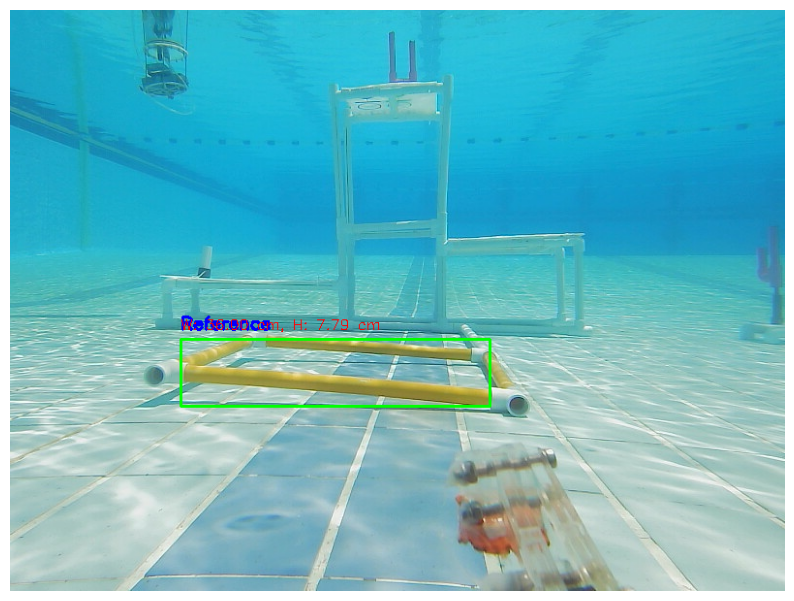

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = r"D:\Vortex\ROV\Phase 2\Tasks2025\task 6\image2.png"  # Path to the true reference image
image = cv2.imread(image_path)

# Define the known reference length (e.g., 36 cm or any length you know)
KNOWN_REFERENCE_LENGTH_CM = 36.0  # Adjust based on actual known dimension

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply color thresholding to isolate yellow structures (adjust HSV as needed)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
yellow_lower = np.array([20, 100, 100])  # Lower bound for yellow
yellow_upper = np.array([30, 255, 255])  # Upper bound for yellow
yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

# Detect contours on the yellow mask
contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Placeholder to calculate scale
scale = None

# Find the reference object to determine the scale
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 1000:  # Adjust area threshold as needed
        x, y, w, h = cv2.boundingRect(contour)

        # Assuming the reference object is the longest yellow structure (e.g., one of the yellow tubes)
        reference_pixel_length = max(w, h)
        scale = KNOWN_REFERENCE_LENGTH_CM / reference_pixel_length
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image, "Reference", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        break

# Check if scale was determined
if scale is None:
    print("Reference object for scale not found.")
else:
    print(f"Scale calculated: {scale:.4f} cm/pixel")

# Measure and annotate other yellow objects based on scale
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 1000:  # Filter small contours
        x, y, w, h = cv2.boundingRect(contour)

        # Calculate the real-world dimensions
        real_width = w * scale
        real_height = h * scale

        # Draw bounding box and annotate dimensions
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f"W: {real_width:.2f} cm, H: {real_height:.2f} cm",
                    (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Display the annotated image
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
